In [1]:
import torch

def quantile_loss(y_pred, y_true):
    mask = (y_true != 0).float()
    mask /= mask.mean()
    quantiles = [0.025, 0.5, 0.975]
    losses = []
    for i, q in enumerate(quantiles):
        errors =  y_true - torch.unbind(y_pred,3)[i]
        errors = errors * mask
        errors[errors != errors] = 0
        losses.append(torch.max((q-1) * errors, q * errors).unsqueeze(0))
    loss = torch.mean(torch.sum(torch.cat(losses, dim=0), dim=0))
    return loss
def masked_mae_loss(y_pred, y_true):
    y_pred = torch.unbind(y_pred,2)[1]
    mask = (y_true != 0).float()
    mask /= mask.mean()
    loss = torch.abs(y_pred - y_true)
    loss = loss * mask
    # trick for nans: https://discuss.pytorch.org/t/how-to-set-nan-in-tensor-to-0/3918/3
    loss[loss != loss] = 0
    return loss.mean()

def masked_mse_loss(y_pred, y_true):
    y_pred = torch.unbind(y_pred,2)[1]
    mask = (y_true != 0).float()
    mask /= mask.mean()
    loss = (y_pred  - y_true) ** 2
    loss = loss * mask
    # trick for nans: https://discuss.pytorch.org/t/how-to-set-nan-in-tensor-to-0/3918/3
    loss[loss != loss] = 0
    return loss.mean()
def width(y_pred, y_true):

    l_x = torch.unbind(y_pred,2)[0]
    f_x = torch.unbind(y_pred,2)[1]
    u_x = torch.unbind(y_pred,2)[2]

    errors =  u_x - l_x
    #print("errors.size = ",errors.size())
    #print(torch.max(y_true - u_x , u_x-u_x).size())
    #print(torch.max(y_true - u_x , u_x-u_x).type())

    errors[errors != errors] = 0

    losses = []
    losses.append(errors.unsqueeze(0))
    width = torch.mean(torch.sum(torch.cat(losses, dim=0), dim=0))
    return width
def mis_loss(y_pred, y_true):

    #print(y_pred.size())   # l(x) f(x) u(x)
    #print(y_true.size())

    mask = (y_true != 0).float()
    mask /= mask.mean()
    quantiles = [0.025, 0.5, 0.975]
    rou = 0.05
    rou = 2.0 / rou

    l_x = torch.unbind(y_pred,2)[0]
    f_x = torch.unbind(y_pred,2)[1]
    u_x = torch.unbind(y_pred,2)[2]

    errors =  u_x - l_x + abs(y_true - f_x)
    #print("errors.size = ",errors.size())
    #print(torch.max(y_true - u_x , u_x-u_x).size())
    #print(torch.max(y_true - u_x , u_x-u_x).type())

    errors = errors + rou * torch.max(y_true - u_x , u_x-u_x) + rou * torch.max(l_x - y_true , u_x-u_x)
    errors = errors * mask
    errors[errors != errors] = 0

    losses = []
    losses.append(errors.unsqueeze(0))
    loss = torch.mean(torch.sum(torch.cat(losses, dim=0), dim=0))
    return loss


In [2]:
import numpy as np

data_quantile_model = np.load('data/quantile_PEMSD8_seed0.npz',allow_pickle=True)


print(data_quantile_model.files)

['mis', 'width', 'mse', 'rmse', 'mae', 'prediction', 'truth']


In [3]:
predeictions_quantile = data_quantile_model['prediction']
truths_quantile = data_quantile_model['truth']
print(predeictions_quantile.shape)
print(truths_quantile.shape)

(12, 3584, 170, 3)
(12, 3584, 170)


In [4]:
#quantile_model for short term

time_steps = 12

batch_size = 128
num_batches = predeictions_quantile.shape[1] // batch_size  

y_pred_batches = predeictions_quantile.reshape(12, num_batches, batch_size, 170, 3)
y_true_batches = truths_quantile.reshape(12, num_batches, batch_size, 170)

quantile_mae_losses = []
quantile_mse_losses = []
quantile_mis_losses = []
quantile_width_losses = []


for j in range(170):
    mae_loss_per_pos = []
    mse_loss_per_pos = []
    mis_loss_per_pos = []
    width_loss_per_pos = []

    for i in range(num_batches):
        y_pred_batch = y_pred_batches[:time_steps, i, :, j,:]
        y_true_batch = y_true_batches[:time_steps, i, :,j]

        mae_loss_batch = masked_mae_loss(torch.tensor(y_pred_batch).float(), torch.tensor(y_true_batch).float())
        mse_loss_batch = masked_mse_loss(torch.tensor(y_pred_batch).float(), torch.tensor(y_true_batch).float())
        mis_loss_batch = mis_loss(torch.tensor(y_pred_batch).float(), torch.tensor(y_true_batch).float())
        width_batch = width(torch.tensor(y_pred_batch).float(), torch.tensor(y_true_batch).float())


        mae_loss_per_pos.append(mae_loss_batch.item())
        mse_loss_per_pos.append(mse_loss_batch.item())
        mis_loss_per_pos.append(mis_loss_batch.item())
        width_loss_per_pos.append(width_batch.item())

    quantile_mae_losses.append(sum(mae_loss_per_pos) / len(mae_loss_per_pos))
    quantile_mse_losses.append(sum(mse_loss_per_pos) / len(mse_loss_per_pos))
    quantile_mis_losses.append(sum(mis_loss_per_pos) / len(mis_loss_per_pos))
    quantile_width_losses.append(sum(width_loss_per_pos) / len(width_loss_per_pos))

In [5]:

data_gpde_quantile_model = np.load('data/gpde_quantile_PEMSD8_seed0.npz',allow_pickle=True)


predeictions_gpde_quantile = data_gpde_quantile_model['prediction']
truths_gpde_uantile = data_gpde_quantile_model['truth']

#gpde_quantile_model

batch_size = 128
num_batches = predeictions_gpde_quantile.shape[1] // batch_size 


y_pred_batches = predeictions_gpde_quantile.reshape(12, num_batches, batch_size, 170, 3)
y_true_batches = truths_gpde_uantile.reshape(12, num_batches, batch_size, 170)


gpde_quantile_mae_losses = []
gpde_quantile_mse_losses = []
gpde_quantile_mis_losses = []
gpde_quantile_width_losses = []


for j in range(170):
    mae_loss_per_pos = []
    mse_loss_per_pos = []
    mis_loss_per_pos = []
    width_loss_per_pos = []

    for i in range(num_batches):
        y_pred_batch = y_pred_batches[:time_steps, i, :, j,:]
        y_true_batch = y_true_batches[:time_steps, i, :,j]

   
        mae_loss_batch = masked_mae_loss(torch.tensor(y_pred_batch).float(), torch.tensor(y_true_batch).float())
        mse_loss_batch = masked_mse_loss(torch.tensor(y_pred_batch).float(), torch.tensor(y_true_batch).float())
        mis_loss_batch = mis_loss(torch.tensor(y_pred_batch).float(), torch.tensor(y_true_batch).float())
        width_batch = width(torch.tensor(y_pred_batch).float(), torch.tensor(y_true_batch).float())

        mae_loss_per_pos.append(mae_loss_batch.item())
        mse_loss_per_pos.append(mse_loss_batch.item())
        mis_loss_per_pos.append(mis_loss_batch.item())
        width_loss_per_pos.append(width_batch.item())

    gpde_quantile_mae_losses.append(sum(mae_loss_per_pos) / len(mae_loss_per_pos))
    gpde_quantile_mse_losses.append(sum(mse_loss_per_pos) / len(mse_loss_per_pos))
    gpde_quantile_mis_losses.append(sum(mis_loss_per_pos) / len(mis_loss_per_pos))
    gpde_quantile_width_losses.append(sum(width_loss_per_pos) / len(width_loss_per_pos))




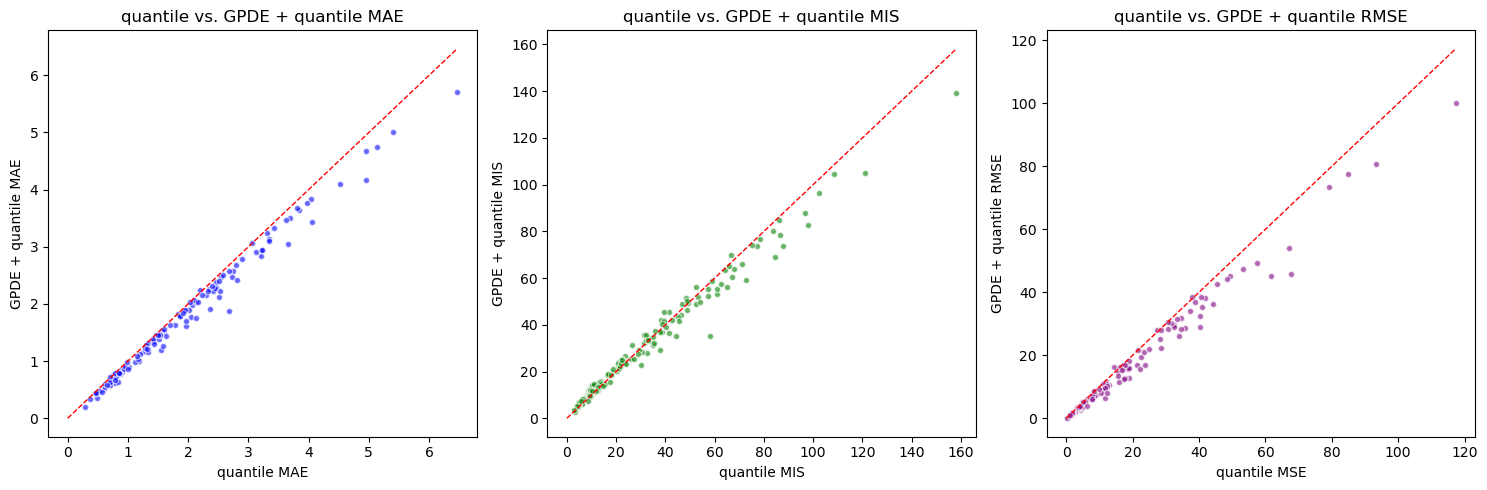

In [6]:
import matplotlib.pyplot as plt
import numpy as np


X1 = quantile_mae_losses
Y1 = gpde_quantile_mae_losses

X2 = quantile_mis_losses
Y2 = gpde_quantile_mis_losses

X3 = quantile_mse_losses
Y3 = gpde_quantile_mse_losses


plt.figure(figsize=(15, 5))  


plt.subplot(1, 3, 1)  
plt.scatter(X1, Y1, color="blue", alpha=0.6, edgecolors="w", s=20)
plt.plot([0, max(max(X1), max(Y1))], [0, max(max(X1), max(Y1))], color="red", linestyle="--", linewidth=1)  
plt.title("quantile vs. GPDE + quantile MAE")
plt.xlabel("quantile MAE")
plt.ylabel("GPDE + quantile MAE")


plt.subplot(1, 3, 2) 
plt.scatter(X2, Y2, color="green", alpha=0.6, edgecolors="w", s=20)
plt.plot([0, max(max(X2), max(Y2))], [0, max(max(X2), max(Y2))], color="red", linestyle="--", linewidth=1)  
plt.title("quantile vs. GPDE + quantile MIS")
plt.xlabel("quantile MIS")
plt.ylabel("GPDE + quantile MIS")

plt.subplot(1, 3, 3)  
plt.scatter(X3, Y3, color="purple", alpha=0.6, edgecolors="w", s=20)
plt.plot([0, max(max(X3), max(Y3))], [0, max(max(X3), max(Y3))], color="red", linestyle="--", linewidth=1) 
plt.title("quantile vs. GPDE + quantile RMSE")
plt.xlabel("quantile MSE")
plt.ylabel("GPDE + quantile RMSE")

plt.tight_layout()  

plt.savefig('outputs/quantile_seperate_PEMSD8_1.png')
plt.show()


In [7]:
data_gpde_quantile_phy_model = np.load('data/gpde_quantile_phy_PEMSD8_seed0.npz',allow_pickle=True)


predeictions_gpde_quantile_phy = data_gpde_quantile_phy_model['prediction']
truths_gpde_quantile_phy = data_gpde_quantile_phy_model['truth']

#gpde_quantile_model

batch_size = 128
num_batches = predeictions_gpde_quantile_phy.shape[1] // batch_size  


y_pred_batches = predeictions_gpde_quantile_phy.reshape(12, num_batches, batch_size, 170, 3)
y_true_batches = truths_gpde_quantile_phy.reshape(12, num_batches, batch_size, 170)


gpde_quantile_phy_mae_losses = []
gpde_quantile_phy_mse_losses = []
gpde_quantile_phy_mis_losses = []
gpde_quantile_phy_width_losses = []


for j in range(170):
    mae_loss_per_pos = []
    mse_loss_per_pos = []
    mis_loss_per_pos = []
    width_loss_per_pos = []

    for i in range(num_batches):
        y_pred_batch = y_pred_batches[:time_steps, i, :, j,:]
        y_true_batch = y_true_batches[:time_steps, i, :,j]


        mae_loss_batch = masked_mae_loss(torch.tensor(y_pred_batch).float(), torch.tensor(y_true_batch).float())
        mse_loss_batch = masked_mse_loss(torch.tensor(y_pred_batch).float(), torch.tensor(y_true_batch).float())
        mis_loss_batch = mis_loss(torch.tensor(y_pred_batch).float(), torch.tensor(y_true_batch).float())
        width_batch = width(torch.tensor(y_pred_batch).float(), torch.tensor(y_true_batch).float())


        mae_loss_per_pos.append(mae_loss_batch.item())
        mse_loss_per_pos.append(mse_loss_batch.item())
        mis_loss_per_pos.append(mis_loss_batch.item())
        width_loss_per_pos.append(width_batch.item())

    gpde_quantile_phy_mae_losses.append(sum(mae_loss_per_pos) / len(mae_loss_per_pos))
    gpde_quantile_phy_mse_losses.append(sum(mse_loss_per_pos) / len(mse_loss_per_pos))
    gpde_quantile_phy_mis_losses.append(sum(mis_loss_per_pos) / len(mis_loss_per_pos))
    gpde_quantile_phy_width_losses.append(sum(width_loss_per_pos) / len(width_loss_per_pos))




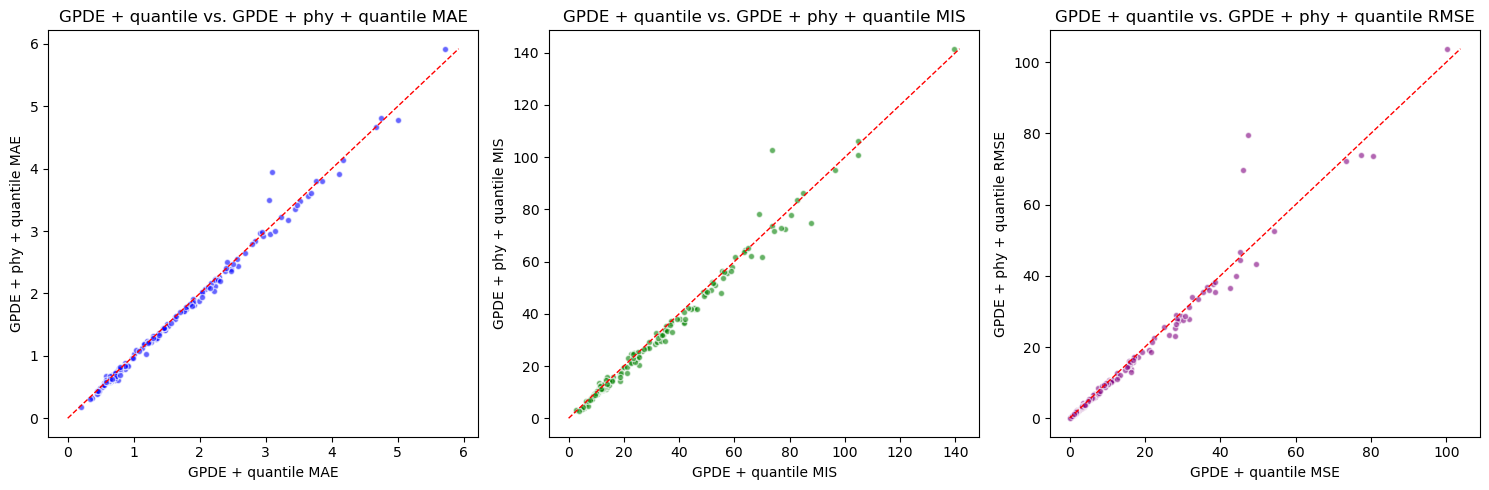

In [8]:
import matplotlib.pyplot as plt
import numpy as np


X1 = gpde_quantile_mae_losses
Y1 = gpde_quantile_phy_mae_losses

X2 = gpde_quantile_mis_losses
Y2 = gpde_quantile_phy_mis_losses

X3 = np.sqrt(gpde_quantile_mse_losses)
Y3 = np.sqrt(gpde_quantile_phy_mse_losses)

X3 = gpde_quantile_mse_losses
Y3 = gpde_quantile_phy_mse_losses


plt.figure(figsize=(15, 5))  


plt.subplot(1, 3, 1)  
plt.scatter(X1, Y1, color="blue", alpha=0.6, edgecolors="w", s=20)
plt.plot([0, max(max(X1), max(Y1))], [0, max(max(X1), max(Y1))], color="red", linestyle="--", linewidth=1) 
plt.title("GPDE + quantile vs. GPDE + phy + quantile MAE")
plt.xlabel("GPDE + quantile MAE")
plt.ylabel("GPDE + phy + quantile MAE")

plt.subplot(1, 3, 2)  
plt.scatter(X2, Y2, color="green", alpha=0.6, edgecolors="w", s=20)
plt.plot([0, max(max(X2), max(Y2))], [0, max(max(X2), max(Y2))], color="red", linestyle="--", linewidth=1)  
plt.title("GPDE + quantile vs. GPDE + phy + quantile MIS")
plt.xlabel("GPDE + quantile MIS")
plt.ylabel("GPDE + phy + quantile MIS")


plt.subplot(1, 3, 3)  
plt.scatter(X3, Y3, color="purple", alpha=0.6, edgecolors="w", s=20)
plt.plot([0, max(max(X3), max(Y3))], [0, max(max(X3), max(Y3))], color="red", linestyle="--", linewidth=1)  
plt.title("GPDE + quantile vs. GPDE + phy + quantile RMSE")
plt.xlabel("GPDE + quantile MSE")
plt.ylabel("GPDE + phy + quantile RMSE")

plt.tight_layout() 

plt.savefig('outputs/quantile_seperate_PEMSD8_2.png')
plt.show()


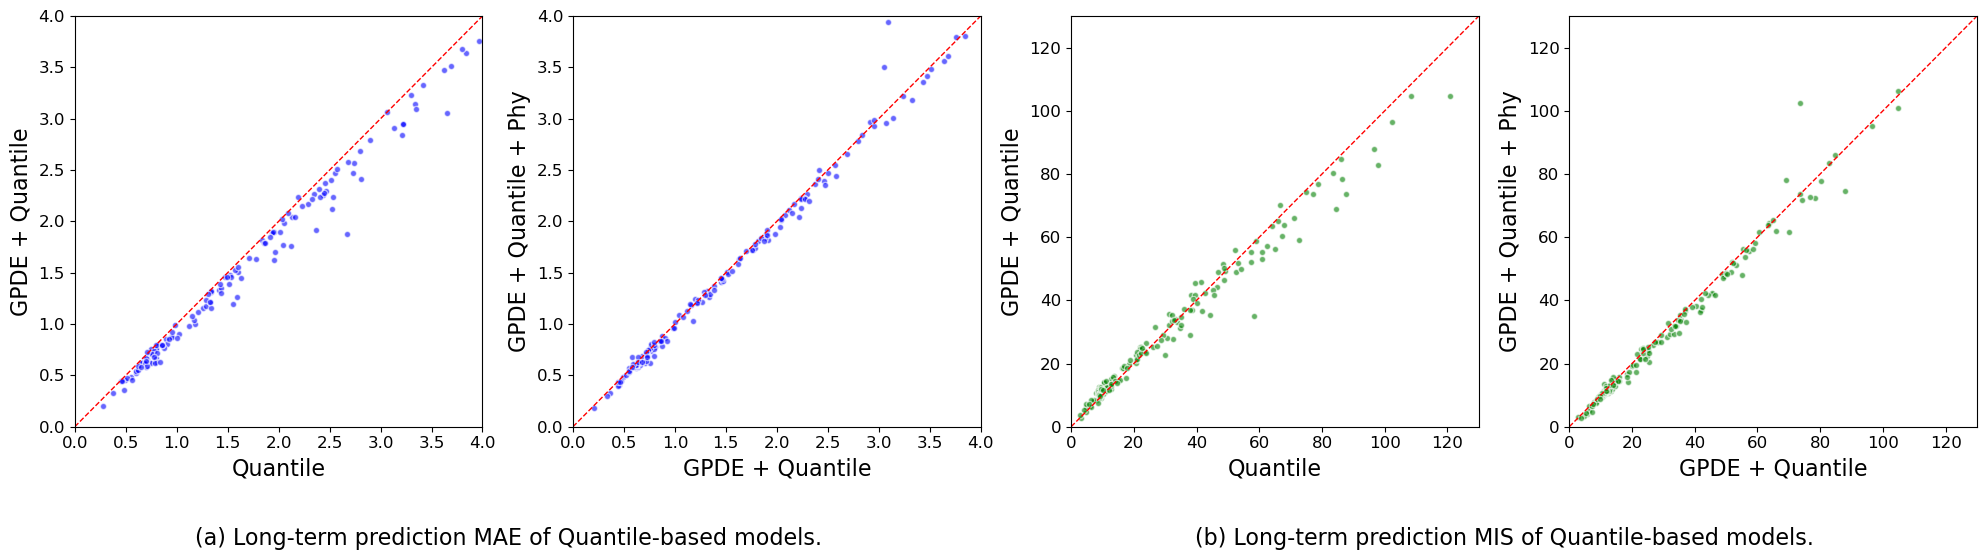

In [9]:
import textwrap
def add_wrapped_text(x, y, text, width, ha='left', fontsize=10):
    wrapped_text = "\n".join(textwrap.wrap(text, width=width))
    plt.figtext(x, y, wrapped_text, ha=ha, fontsize=fontsize)

X1 = quantile_mae_losses
Y1 = gpde_quantile_mae_losses

X2 = gpde_quantile_mae_losses
Y2 = gpde_quantile_phy_mae_losses

#X3 = quantile_mse_losses
#Y3 = gpde_quantile_mse_losses

#X4 = gpde_quantile_mse_losses
#Y4 = gpde_quantile_phy_mse_losses
# X3 = quantile_mis_losses
# Y3 = gpde_quantile_mis_losses

X4 = gpde_quantile_mis_losses
Y4 = gpde_quantile_phy_mis_losses

X3 = quantile_mis_losses
Y3 = gpde_quantile_mis_losses

plt.rcParams['axes.labelsize'] = 16  
plt.rcParams['axes.titlesize'] = 16  
plt.rcParams['legend.fontsize'] = 12  
plt.rcParams['xtick.labelsize'] = 12  
plt.rcParams['ytick.labelsize'] = 12  



X1 = np.array(X1)
Y1 = np.array(Y1)
X2 = np.array(X2)
Y2 = np.array(Y2)
X3 = np.array(X3)
Y3 = np.array(Y3)
X4 = np.array(X4)
Y4 = np.array(Y4)

x_min_12 = 0
x_max_12 = 4
y_min_12 = 0
y_max_12 = 4

x_min_34 = 0
x_max_34 = 130
y_min_34 = 0
y_max_34 = 130

plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.scatter(X1, Y1, color="blue", alpha=0.6, edgecolors="w", s=20)
plt.plot([0, max(x_max_12, y_max_12)], [0, max(x_max_12, y_max_12)], color="red", linestyle="--", linewidth=1)
plt.xlabel("Quantile")
plt.ylabel("GPDE + Quantile")
plt.xlim(x_min_12, x_max_12)
plt.ylim(y_min_12, y_max_12)


plt.subplot(1, 4, 2)
plt.scatter(X2, Y2, color="blue", alpha=0.6, edgecolors="w", s=20)
plt.plot([0, max(x_max_12, y_max_12)], [0, max(x_max_12, y_max_12)], color="red", linestyle="--", linewidth=1)
plt.xlabel("GPDE + Quantile")
plt.ylabel("GPDE + Quantile + Phy")
plt.xlim(x_min_12, x_max_12)
plt.ylim(y_min_12, y_max_12)

plt.subplot(1, 4, 3)
plt.scatter(X3, Y3, color="green", alpha=0.6, edgecolors="w", s=20)
plt.plot([0, max(x_max_34, y_max_34)], [0, max(x_max_34, y_max_34)], color="red", linestyle="--", linewidth=1)
plt.xlabel("Quantile")
plt.ylabel("GPDE + Quantile")
plt.xlim(x_min_34, x_max_34)
plt.ylim(y_min_34, y_max_34)

plt.subplot(1, 4, 4)
plt.scatter(X4, Y4, color="green", alpha=0.6, edgecolors="w", s=20)
plt.plot([0, max(x_max_34, y_max_34)], [0, max(x_max_34, y_max_34)], color="red", linestyle="--", linewidth=1)
plt.xlabel("GPDE + Quantile")
plt.ylabel("GPDE + Quantile + Phy")
plt.xlim(x_min_34, x_max_34)
plt.ylim(y_min_34, y_max_34)

add_wrapped_text(0.1, -0.1, "(a) Long-term prediction MAE of Quantile-based models. ", width=80, fontsize=16)

add_wrapped_text(0.6, -0.1, "(b) Long-term prediction MIS of Quantile-based models. ", width=80, fontsize=16)


plt.tight_layout()

plt.savefig('outputs/quantile_seperate_PEMSD8_3.png')
plt.show()

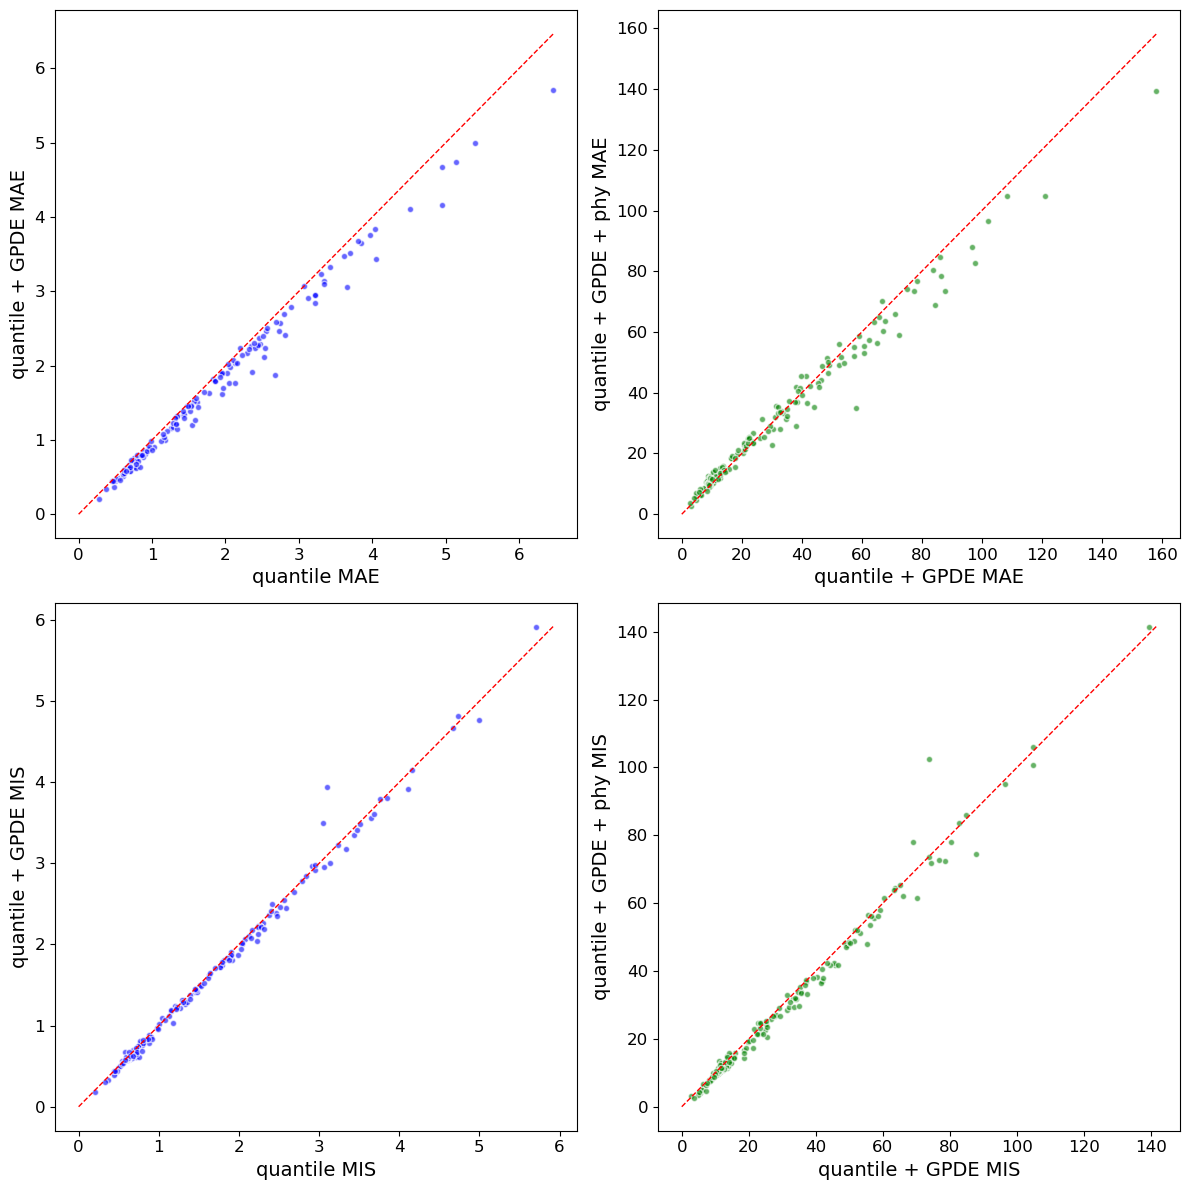

In [10]:

X1 = quantile_mae_losses
Y1 = gpde_quantile_mae_losses

X3 = quantile_mis_losses
Y3 = gpde_quantile_mis_losses

X2 = gpde_quantile_mae_losses
Y2 = gpde_quantile_phy_mae_losses

X4 = gpde_quantile_mis_losses
Y4 = gpde_quantile_phy_mis_losses


plt.figure(figsize=(12, 12))  


plt.subplot(2, 2, 1)  
plt.scatter(X1, Y1, color="blue", alpha=0.6, edgecolors="w", s=20)
plt.plot([0, max(max(X1), max(Y1))], [0, max(max(X1), max(Y1))], color="red", linestyle="--", linewidth=1) 
#plt.title("GPDE + quantile vs. GPDE + phy + quantile MAE")
plt.xlabel("quantile MAE",fontsize = 14)
plt.ylabel("quantile + GPDE MAE",fontsize = 14)


plt.subplot(2, 2, 3) 
plt.scatter(X2, Y2, color="blue", alpha=0.6, edgecolors="w", s=20)
plt.plot([0, max(max(X2), max(Y2))], [0, max(max(X2), max(Y2))], color="red", linestyle="--", linewidth=1)  
#plt.title("GPDE + quantile vs. GPDE + phy + quantile MIS")
plt.xlabel("quantile MIS",fontsize = 14)
plt.ylabel("quantile + GPDE MIS",fontsize = 14)


plt.subplot(2, 2, 2)  
plt.scatter(X3, Y3, color="green", alpha=0.6, edgecolors="w", s=20)
plt.plot([0, max(max(X3), max(Y3))], [0, max(max(X3), max(Y3))], color="red", linestyle="--", linewidth=1)  
#plt.title("GPDE + quantile vs. GPDE + phy + quantile MAE")
plt.xlabel("quantile + GPDE MAE",fontsize = 14)
plt.ylabel("quantile + GPDE + phy MAE",fontsize = 14)


plt.subplot(2, 2, 4)  
plt.scatter(X4, Y4, color="green", alpha=0.6, edgecolors="w", s=20)
plt.plot([0, max(max(X4), max(Y4))], [0, max(max(X4), max(Y4))], color="red", linestyle="--", linewidth=1)  
#plt.title("GPDE + quantile vs. GPDE + phy + quantile MIS")
plt.xlabel("quantile + GPDE MIS",fontsize = 14)
plt.ylabel("quantile + GPDE + phy MIS",fontsize = 14)

plt.tight_layout()  

plt.savefig('outputs/quantile_seperate_PEMSD8_4.png')
plt.show()

